# <center> Single Channel Queuing Example
## <center> Systems Engineering and Analysis
## <center> <img src="https://www.engr.colostate.edu/~jdaily/Systems-EN-CSU-1-C357.svg" width="400" /> 
### <center> Prepared by: Dr. Jeremy Daily

## The M/M/1 Queue System

The M/M/1 Queue is named using the Kendall Notation, which denotes teh arrival process, the service time distribution, and the number of service units. 

The M stands for Markovian (or Memoryless). It uses an exponential distribution to describe the time spacing of the arrival or servicing events. 


https://en.wikipedia.org/wiki/Kendall%27s_notation

The SYSE530 course text describes this system in Section 10.3 as Single-Channel Queuing Model.

https://en.wikipedia.org/wiki/M/M/1_queue

Some additional reading for fun:

https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, expon

### Number of Arrivals per Time Period
In the following block, we'll simulate a Poisson distribution to describe the number of units arriving to a queuing system. We'll be using the documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html

For additional context, see https://en.wikipedia.org/wiki/Poisson_point_process.

From the example on Page 299 of B&F, suppose a queue experiences Poisson arrives with a mean rate of 1/10 units per time period. This means 
$$ \lambda = 10 $$
in the book's notation. 

average number of arrivals per time = 10


Text(0.5, 0, 'Number of arrivals')

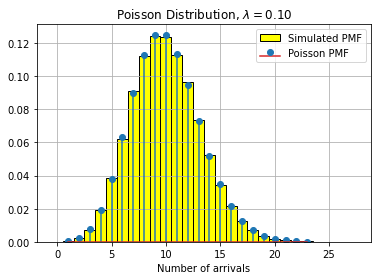

In [2]:
N=100000

arrival_rate_mean = 10

# Specify  the number of arrivals per period
# use lam instead of lambda because lambda is a protected word in Python
lam = 1/arrival_rate_mean

print("average number of arrivals per time = {}".format(arrival_rate_mean))

#Generate random values from the poisson distribution
arrival_counts = poisson.rvs(arrival_rate_mean,size=N)

#place the bins in the center of the discrete values for the samples
bins = np.arange(0, max(arrival_counts) + 1.5) - 0.5

#Show the emperical distribution of the generated random values
plt.hist(arrival_counts,bins=bins,density=True,color="yellow",ec="black",label="Simulated PMF");

#Generate a range for the theoretical mass function
x = np.arange(poisson.ppf(0.0001, arrival_rate_mean),
              poisson.ppf(0.9999, arrival_rate_mean))
#Plot the theoretical PMF
plt.stem(x, poisson.pmf(x, arrival_rate_mean),   label='Poisson PMF')
plt.legend()
plt.grid()
plt.title("Poisson Distribution, $\lambda = {:0.2f}$".format(lam));
plt.xlabel("Number of arrivals")

In [4]:
#compare simulation mean 
arrival_counts.mean()

9.99975

### Time between each arrival
The space between each arrival in Poisson process is distributed as an exponential distribution.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html

The scale factor for the distribution is $1/\lambda $ which equals the arrival rate.

We'll simulate the arrival spacing for the queue.

NameError: name 'scale' is not defined

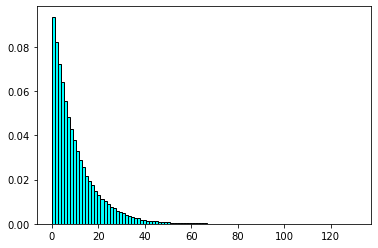

In [5]:
#Show the emperical distribution of the generated random values
#place the bins in the center of the discrete values for the samples
arrival_intervals = expon.rvs(scale=arrival_rate_mean,size=N)
plt.hist(arrival_intervals,bins=100,density=True,color="cyan",ec="black",label="Simulated PDF");
#Generate a range for the theoretical mass function
x = np.arange(expon.ppf(0.0001, scale=scale),
              expon.ppf(0.9999, scale=scale),0.01)
#Plot the theoretical PMF
plt.plot(x, expon.pdf(x, scale=arrival_rate_mean),  'r-', label='Exponential PDF')
plt.legend()
plt.grid()
plt.xlabel("Time Spacing for a Poisson Process")
plt.ylabel("Probability Density Function");

In [6]:
# Determine theoretical moments for the distribution
mean, var, skew, kurt = expon.stats(scale=arrival_rate_mean,moments='mvsk')
print(mean, var, skew, kurt)

10.0 100.0 2.0 6.0


In [7]:
#Compare to the simulated distribution
arrival_intervals.mean()

9.991283502090731

In [8]:
#Theoretical mean
1/lam

10.0

In [9]:
#Compare to the simulated distribution variance
arrival_intervals.var()

100.04671465882879

### Simulate the distribution describing time for servicing
This is also an exponential distribution

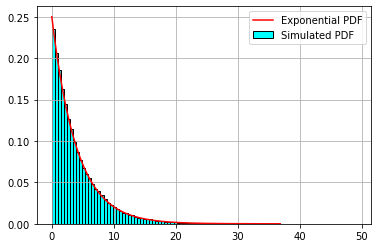

In [13]:
#Generate random values from the exponential distribution
service_time_mean = 4
# Determine the service rate
mu = 1/service_time_mean #Book notation for service completions per period

service_times = expon.rvs(scale=service_time_mean,size=N)

#place the bins in the center of the discrete values for the samples
bins = 100

#Show the emperical distribution of the generated random values
plt.hist(service_times,bins=bins,density=True,color="cyan",ec="black",label="Simulated PDF");

#Generate a range for the theoretical mass function
x = np.arange(expon.ppf(0.0001, scale=service_time_mean),
              expon.ppf(0.9999, scale=service_time_mean),0.01)
#Plot the theoretical PMF
plt.plot(x, expon.pdf(x, scale=service_time_mean),  'r-', label='Exponential PDF')
plt.legend()
plt.grid()

In [14]:
mean, var, skew, kurt = expon.stats(scale=service_time_mean,moments='mvsk')
print(mean, var, skew, kurt)

4.0 16.0 2.0 6.0


In [15]:
#theroretical expected value (mean)
1/mu

4.0

In [16]:
#Compare to the simulated distribution
np.array(service_times).mean()

4.011525817694604

In [17]:
#Theoretical variance
1/mu**2 

16.0

In [18]:
#Compare to the simulated distribution
np.array(service_times).var()

16.181097100351312

### Will there be convergence?
This is the first check for a queue. Will the queue be able to handle the in-flux. The processing has to be faster than the arrivals or else the queue will back up. See the note after Eqn. 10.9 in B&F.

In [19]:
# check the ratio to see if it is less than 1 to get convergence
print(lam/mu)
if lam/mu < 1:
    print("Convergence Criteria Achieved.")
else:
    print("Queue will not converge. The arrivals are faster than the servicing")

0.4
Convergence Criteria Achieved.


## Simulate a Queuing System
We'll setup a routine that loops through time and processes "customers." The customer arrival time is separated by a random time that is exponentially distributed. The processing time will be determined by a random sample from another exponential distribution. With both of these distributions as exponential, we can determine theoretical properties for the M/M/1 system. 

The customer has it's own needs, so we'll define it's servicing time when the customer is created (i.e. arrives to the queue).

We'll use an object-oriented approach and create a class the defines the customer and some of it's properties and functions. 

In [20]:
#Create an object that can keep track of itself through the system
# Pass in an identifier and the global arrival time. 
class Customer():
    def __init__(self,id,arrival):
        self.id = id
        self.wait_time = 0
        self.arrival_time = arrival
        #Use a sample from a random variable for the service time
        self.service_time = expon.rvs(scale=service_time_mean) 
        # This is a minimum. It will be updated upon ejection from the queue system
        self.finished_time = self.arrival_time + self.service_time + self.wait_time
        
    def get_queue_time(self):
        self.queue_time = self.finished_time - self.arrival_time
        return self.queue_time

### Simulate the Queue
This is a Monte Carlo simulation of the Single Channel Queuing Model as described in Section 10.3 of B&F.

In [21]:
# This is for printout of the queue simulation
# Set this to zero to suppress output
debug_periods = 0
delta_t = .05

# Initialize some lists to keep track of the queue performance.
finished_customers = []
customers_in_line = []
customers_in_system = []
customer_wait_time = []
customer_system_time = []


# Specify the number of time periods to run
# Iterate to find convergence.
for time_periods in [1000000,2000000,4000000]:
   

    # Make an ordered list the waiting line of the queue system
    # We can add elements uing the append method
    # We can remove elements using the pop method
    waiting_line = []


    system_size=0
    arrivals = 0
    arrival_time = 0
    # This creates and instance of the customer
    # We pass the id of the customer into the constructor
    # The first time is zero (second argument)
    # If the service_cust is defined, then it is in service. 
    service_cust = Customer(arrivals,arrival_time)
    # Always add one when the customer is created
    system_size += 1
    # Always update the arrival time of the next customer with a sample from the 
    # exponential distribution
    arrival_time += expon.rvs(scale=arrival_rate_mean)


    t=0
    for n in range(time_periods):
        # Calculate the current time as t
        t += delta_t

        # Keep track of how many customers are in the system
        customers_in_system.append(system_size)
        # Keep track of customers in line
        customers_in_line.append(len(waiting_line))

        # Check for new arrivals
        if t >= arrival_time:
            arrivals += 1
            # Create a customer to simulate an arrival. 
            # The customer class generates its own servicing time.
            cust = Customer(arrivals,arrival_time)
            # Always increase the number of customers in the system
            system_size += 1

            # update the arrival time with the next arrival
            arrival_time += expon.rvs(scale=arrival_rate_mean)

            if t < debug_periods:
                print("t = {}, waiting_line length = {}".format(t,len(waiting_line)))
                print("Created Customer {} at time {} with service time of {}".format(cust.id, cust.arrival_time, cust.service_time))

            # Put the newly created customer in the wait line
            waiting_line.append(cust)

        # Check to see if a customer is finished
        #Be sure there is a customer in service
        if service_cust is not None:
            # Since the customer is in service, we should see if it's done.
            if t >= service_cust.finished_time:
                if t < debug_periods:
                    print("Customer {} finished at time {}".format(service_cust.id, t))
                # Keep track of customers coming through the queue
                finished_customers.append(service_cust)
                customer_system_time.append(service_cust.get_queue_time())
                # Remove the customer from the system.
                system_size -= 1
                # Let the program know there is no customer being serviced.
                service_cust = None
        else:
            #There's no customer in service, so only the ones in the line are in the system
            try:
                # Get a customer from the line
                service_cust = waiting_line.pop(0)
            except IndexError:
                # There wasn't anyone in line, so move to the next time.
                continue
            # determine how long they were in the wait line    
            service_cust.wait_time = t - service_cust.arrival_time
            # Keep track of the wait time.
            customer_wait_time.append(service_cust.wait_time)
            # Determine when the finish should be
            service_cust.finished_time = t + service_cust.service_time
            
            if t < debug_periods:
                print("Retrieved Customer {} from the line at time {:0.3f} after waiting {:0.3f}.".format(service_cust.id, t, service_cust.wait_time))
                print("Anticipated finish for {} is {:0.3F}".format(service_cust.id,service_cust.finished_time))
    print("np.mean(customers_in_system)",np.mean(customers_in_system[int(time_periods/4):]))

np.mean(customers_in_system) 0.6707893333333333
np.mean(customers_in_system) 0.700094
np.mean(customers_in_system) 0.682657


Note: Convergence is slow for this system. Orders of magnitude more samples are required for convergence

### Average number of customers waiting in line

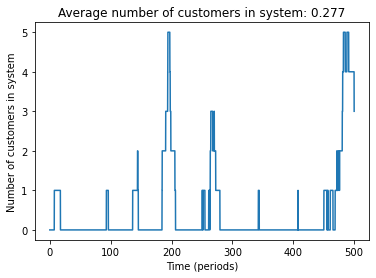

In [24]:
average_number_in_line = np.mean(customers_in_line)
times = np.arange(N)*delta_t
plt.plot(times,customers_in_line[:N])
plt.xlabel("Time (periods)")
plt.ylabel("Number of customers in system")
plt.title("Average number of customers in system: {:0.3f}".format(average_number_in_line));

In [40]:
# Theoretical average length of line
# See Equation 10.11
L_q = lam**2/(mu*(mu-lam))
L_q

0.2666666666666667

### Average waiting time for customers in line

In [26]:
# Average simulated time in line
np.mean(customer_wait_time)

2.790201712313725

In [41]:
# Theoretical mean time an arrival waits for service
# Equation 10.18
W_q = lam/(mu*(mu-lam))
W_q

2.666666666666667

### Average time spent in the queuing system

In [28]:
# Average simulated time in the whole system
np.mean(customer_system_time)

6.775439354275095

In [29]:
# Theoretical average customer time through the queue.
# Equation 10.19
t_m = 1/(mu-lam)
t_m

6.666666666666667

### Average number of customers in the system
This includes both customers in line and customers being serviced.

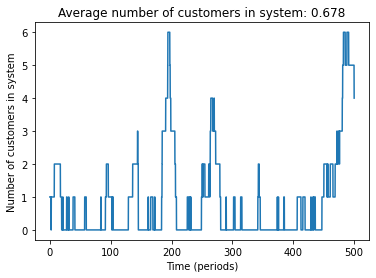

In [22]:
# Incorporate less samples to see the operation of the queue
# Also include some measures
average_number_in_system = np.mean(customers_in_system)
#Reduce the samples for faster plotting
N = int(500/delta_t)
times = np.arange(N)*delta_t
plt.plot(times,customers_in_system[:N])
plt.xlabel("Time (periods)")
plt.ylabel("Number of customers in system")
plt.title("Average number of customers in system: {:0.3f}".format(average_number_in_system));

In [39]:
# Mean theoretical length or elements in the system
# Equation 10.10
L = lam/(mu-lam)
L

0.6666666666666667

In [32]:
# Probability of size of the line at any time (steady state)
#Eq 10.9
def Pn(n,l=lam,mu=mu):
    assert type(n)==int
    return (1-l/mu)*(l/mu)**n

pmf=[]
x = []
expected_val = 0
for n in range(15):
    x.append(n)
    pmf.append(Pn(n))
    print(n,Pn(n))
    
    expected_val += n*Pn(n)

0 0.6
1 0.24
2 0.09600000000000002
3 0.03840000000000001
4 0.015360000000000002
5 0.006144000000000001
6 0.0024576000000000008
7 0.0009830400000000003
8 0.0003932160000000002
9 0.00015728640000000008
10 6.291456000000003e-05
11 2.5165824000000015e-05
12 1.0066329600000006e-05
13 4.026531840000002e-06
14 1.6106127360000012e-06


In [33]:
#Expected Value Verification
print(expected_val,"=?=",L)

0.6666498447114242 =?= 0.6666666666666667


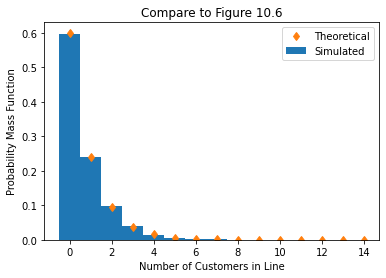

In [35]:
# This cell takes a while with large samples
#place the bins in the center of the discrete values for the samples
bins = np.arange(0, max(customers_in_system) + 1.5) - 0.5
vals,bins,_ = plt.hist(customers_in_system, bins=bins, density=True,label="Simulated")
plt.plot(x,pmf,'d',label="Theoretical")
plt.xlabel("Number of Customers in Line")
plt.ylabel("Probability Mass Function")
plt.title("Compare to Figure 10.6")
plt.legend();

In [37]:
# Compute the expected value of the simulated distribution 
expected_sum = 0
for v,b in zip(vals,bins):
    expected_sum += v*(b+.5)
#this should closely match the average_number_in_system
expected_sum

0.6782171428571431

In [38]:
# This is the same as before
average_number_in_system

0.6782171428571429